# Préparation

In [ ]:
!pip install panns_inference

In [ ]:
import os
import pandas as pd
import numpy as np
import torchaudio
from google.colab import files
from panns_inference import AudioTagging, SoundEventDetection
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
from torchsummary import summary

In [ ]:
# Charger le modèle sur CNN14
audio_tagging = AudioTagging(checkpoint_path=None)

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth


/usr/local/lib/python3.10/dist-packages/panns_inference/inference.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=

GPU number: 1


In [ ]:
input_file = 'annotations_test.xlsx'

# Charger le fichier Excel
df = pd.read_excel(input_file)

# Ajouter une colonne pour les embeddings
df["embeddings"] = None

# Ajouter chaque embeddings de chaque instance dans le dataframe
for index, row in df.iterrows():
    try:
      # Charger la donnée audio depuis la source
      wav_path = '/content/' + str(row['filename'])

      # Obtenir le bon format
      waveform, sample_rate = torchaudio.load(wav_path)

      # Applique le modèle d'extraction d'embeddings à des données audio WAV
      _, embedding = audio_tagging.inference(waveform)

      # Ajouter le résultat dans le DataFrame
      df.at[index, "embeddings"] = embedding
    except Exception as e:
        print(f"Erreur")

In [ ]:
# Dataset des données pour le dataloader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = torch.tensor(data["embeddings"].tolist(), dtype=torch.float32)
        self.labels = torch.tensor(data["target"].tolist(), dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Création des datasets
test_dataset = CustomDataset(df)

In [ ]:
# Création des DataLoaders
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Entrée : Un vecteur de taille 2048 (représentant un embedding)
# Couche cachée : des couches denses avec 128 neurones et une activation ReLU (pleinement connectées)
# Couche sortie : nombre de classe

class MLP(nn.Module):
    def __init__(self, input_size = 2048, num_classes = 5):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)

        self.relu = nn.ReLU()

        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.out(x)
        return x

# Initialisation du modèle
model = MLP(input_size=2048, num_classes= 5).to('cuda')

# Résumé de l'architecture
summary(model, input_size=(2048,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         262,272
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 5]             645
Total params: 295,941
Trainable params: 295,941
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 1.13
Estimated Total Size (MB): 1.14
----------------------------------------------------------------


# Chargement du modèle déjà entrainé

In [ ]:
# Charger le modèle
model = MLP()
model.load_state_dict(torch.load('MLP_on_CNN14.pth'))
model.to('cuda')

<ipython-input-124-6df0428da886>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('MLP_on_CNN14.pth'))


MLP(
  (layer1): Linear(in_features=2048, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (out): Linear(in_features=128, out_features=5, bias=True)
)

# Inférence

In [ ]:
input_file = 'annotations_test.xlsx'
output_file = 'test_predictions_CNN14.xlsx'

# Charger le fichier Excel
df = pd.read_excel(input_file)

# Ajouter une colonne pour les embeddings
df["embeddings"] = None

# Ajouter une colonne pour la prédiction
df['Prediction'] = None

model.eval()
with torch.no_grad():
  # Ajouter chaque embeddings de chaque instance dans le dataframe
  for index, row in df.iterrows():
      try:
        # Charger la donnée audio depuis la source
        wav_path = '/content/' + str(row['filename'])

        # Obtenir le bon format
        waveform, sample_rate = torchaudio.load(wav_path)

        # Applique le modèle d'extraction d'embeddings à des données audio WAV
        _, embedding = audio_tagging.inference(waveform)

        embedding_torch = torch.from_numpy(embedding).unsqueeze(0).float().to('cuda')

        # Inférence avec le modèle
        outputs = model(embedding_torch).squeeze(1)

        # Déterminer la classe prédite
        prediction = torch.argmax(outputs, dim=1).item()

        # # Ajouter le résultat dans le DataFrame
        df.at[index, "embeddings"] = embedding
        df.at[index, "Prediction"] = prediction
      except Exception as e:
          print(f"Erreur")

# Sauvegarder le DataFrame avec les prédictions dans un nouveau fichier Excel
df.to_excel(output_file, index=False)

# Pour apprentissage actif au besoin

In [ ]:
# Téléchargement des résultats de l'inférence
files.download('test_predictions_CNN14.xlsx')
!wget -O annotations_inference_v2.xlsx

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


# Évaluation

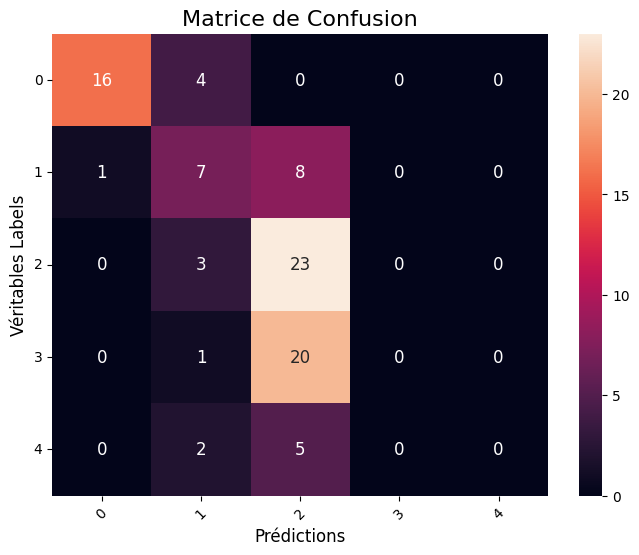

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mettre les labels dans une liste
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:

        # X (embedding), y (target)
        features, labels = features.to('cuda'), labels.to('cuda')

        # Inférence avec le modèle
        outputs = model(features).squeeze(1)

        # Déterminer la classe prédite
        predictions = torch.argmax(outputs, dim=1)

        # Ajouter les labels et prédictions aux listes
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Convertir en tableaux numpy
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=True, annot_kws={'size': 12})
plt.title('Matrice de Confusion', fontsize=16)
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Véritables Labels', fontsize=12)

# Ajuster les labels
classes = range(len(conf_matrix))
plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=45)
plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)

plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calcul des métriques micro
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='micro'
)

# Calcul des métriques macro
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='macro'
)

# Afficher les résultats
print(f"Accuracy: {accuracy:.2f}")

print("\n=== Micro Scores ===")
print(f"Micro Précision: {micro_precision:.2f}")
print(f"Micro Rappel: {micro_recall:.2f}")
print(f"Micro F1-Score: {micro_f1:.2f}")

print("\n=== Macro Scores ===")
print(f"Macro Précision: {macro_precision:.2f}")
print(f"Macro Rappel: {macro_recall:.2f}")
print(f"Macro F1-Score: {macro_f1:.2f}")

Accuracy: 0.51

=== Micro Scores ===
Micro Précision: 0.51
Micro Rappel: 0.51
Micro F1-Score: 0.51

=== Macro Scores ===
Macro Précision: 0.35
Macro Rappel: 0.42
Macro F1-Score: 0.37


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
